In [19]:
import os
import json
from pathlib import Path
from tempfile import TemporaryFile

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
import scipy.special as sps
import pyvista as pv
import trimesh
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
data_dir = Path("/home/max/Desktop/python_projects/")
root = data_dir / "SimJEB_surfmesh"
dest = data_dir / "SimJEB_sdf"

In [16]:
paths = []
for path in root.glob("*.obj"):
    paths.append(path)

In [39]:
margin = 0.2
num_samples = 250000
uniform_fraction = 0.2

num_perturb_samples = int(num_samples * (1 - uniform_fraction))
num_uniform_samples = num_samples - num_perturb_samples
for path in tqdm(paths):
    mesh_orig = pv.read(path)
    mesh = mesh_orig.extract_surface().triangulate()
    bounds = np.array(mesh.bounds).reshape((3,2)).copy()
    
    max_permutation = min(bounds[:,1] - bounds[:,0]) * margin
    s = np.random.default_rng().gamma(1., 1., num_perturb_samples)
    median = (min(s) + max(s)) / 2
    s[s > median] = median
    s *= max_permutation / median
    rnd_sign = np.random.choice([-1, 1], size=num_perturb_samples)
    s *= rnd_sign
    
    faces_as_array = mesh.faces.reshape((-1, 4))[:, 1:]
    tr_mesh = trimesh.Trimesh(vertices=mesh.points, faces=faces_as_array)
    samples, face_index = trimesh.sample.sample_surface(tr_mesh, num_perturb_samples)
    normals = tr_mesh.face_normals[face_index]
    samples += normals * s.reshape(-1,1)
    
    center = ((bounds[:,0] + bounds[:,1]) / 2).reshape((3,1))
    bounds = (bounds - center) * (1 + margin * 2) + center
    uniform_samples = np.random.uniform(low=bounds[:,0], high=bounds[:,1], size=(num_uniform_samples, 3))
    
    samples = np.vstack([samples, uniform_samples])
    pv_samples = pv.PolyData(samples)
    _ = pv_samples.compute_implicit_distance(mesh_orig, inplace=True)
    
    distances = pv_samples["implicit_distance"].reshape((-1,1))
#     pv_samples.save(data_dir / "SimJEB_sdf" / f"{path.stem}.vtk")
    
    data = np.hstack([samples, distances])
    
    with open(data_dir / "SimJEB_sdf" / f"{path.stem}.npy", "wb") as f:
        np.save(f, data)

  0%|                                                   | 0/381 [00:08<?, ?it/s]


In [23]:
mesh.faces.shape

(125616,)

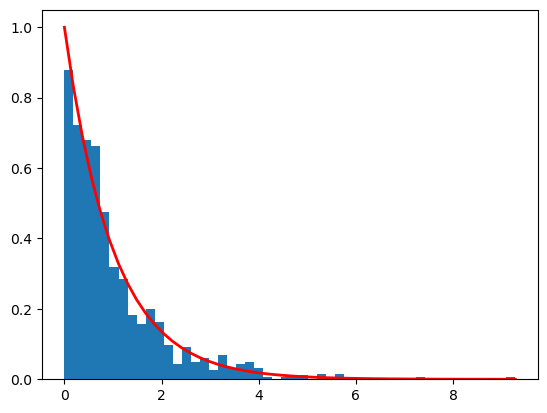

In [15]:
shape, scale = 1., 1.  # mean=4, std=2*sqrt(2)
s = np.random.default_rng().gamma(shape, scale, 1000)
count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.show()